# Sequential Testing Experiment with Conjugate Models

In [1]:
# setup noteoobk environment
import Pkg
Pkg.activate(".")
Pkg.instantiate();

using Random 
using Plots

using BayesianExperiments

## Two Models

We want to compare two variants with ratios. For example, we have a new UI design and want to compare its CTR (click-through-rate) to the CTR of the existing design. In this case we can create two Bernoulli models to model the CTR's of each variant. 

A Bernoulli model is a model with Bernoulli distribution as the likelihood and Beta distribution as the prior. In the beginning, we set $\alpha=10$ and $\beta=90$ as parameters of the prior. (We will talk about the impact of priors and how to choose a "proper" prior for you experiment in details later).

In [2]:
α = 1
β = 1
modelA = ConjugateBernoulli(α, β)
modelB = ConjugateBernoulli(α, β)
models = [modelA, modelB]
modelnames = ["control", "variant 1"];

We want to use "expected loss" as the key metric for our decision, and a "threshold of caring" of 0.0001 as the stopping rule of our experiment. An expected loss can be think as the "average" loss that we will get if our decision is wrong. It depends on how likely our decision is wrong, and how much loss we will get when our decision is wrong.

In [3]:
thresh = 1e-4
stoppingrule = ExpectedLossThresh(thresh);

An experiment is a combination of underlying models and the stopping rule that we chose before.

In [4]:
experiment = ExperimentAB(models, stoppingrule, modelnames=modelnames);

Now we start to collect real data in our online experiment. Let's make some assumptions to demonstrate the idea:
1. The underlying data generating distributions follow Bernoulli distributions with parameters 0.01 and 0.0102. And That means our new design has 2% higher CTR than the current one.
2. We use $20%$ of the total traffic to test the new design. At each day, we can collect 4000 and 1000 observations for "control" and "variant 1". 

We will update the models as we collect more data and monitor the change of our expected loss. Our rule is quite simple: if the expected loss of one group is below the threshold, we can stop the experiment and make decision. And we will collect for maximum 15 days and declare no winner if there is no group with expected loss below the threshold.

In [5]:
max_days = 15

Random.seed!(12)
expected_losses = Vector{Float64}[]
day = 0
for _ = 1:max_days
    day += 1
    # we collect data every day
    dataA = rand(Bernoulli(0.0100), 4000)
    dataB = rand(Bernoulli(0.0102), 1000)
    
    # convert data into statistics
    statsA = BernoulliStatistics(dataA)
    statsB = BernoulliStatistics(dataB)
    
    # update the models in the experiment with the statistics
    update!(experiment, [statsA, statsB])
    
    # calculate the metrics (expected loss)
    # this step is optional, for visualization below
    _, losses = metrics(experiment)
    push!(expected_losses, losses)
    
    # select winner, get "nothing" if there is no winner
    winner = decide!(experiment)
    
    # stop the experiment if we already find a winner
    if winner !== nothing
        break
    end
end

Now we can visualize the expected losses over days. We can see the expected loss of "variant 1" is decreasing over days. And at day 7 we find its expected loss is below the threshold in our stopping rule.

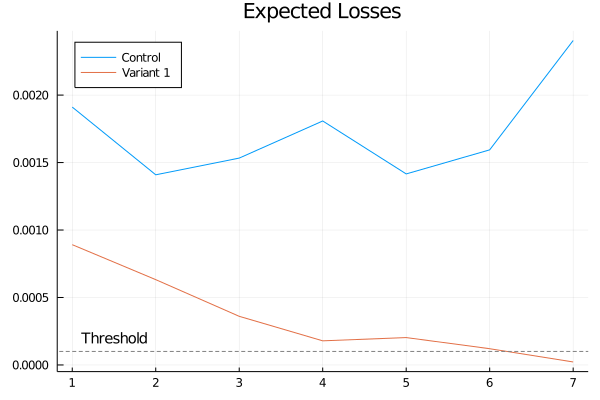

In [6]:
plot(collect(1:day), catbyrow(expected_losses), 
    title="Expected Losses",
    label=["Control" "Variant 1"],
    legend=:topleft,)
hline!([thresh], color=:grey, line=:dash, label=:none)
annotate!(1.5, 0.0002, text("Threshold", 10))